In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import category_encoders as ce
import os
import pickle
import gc
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit

Using TensorFlow backend.


In [2]:
def encode_text_features(encode_decode, data_frame, encoder_isa=None, encoder_mem_type=None):
    # Implement Categorical OneHot encoding for ISA and mem-type
    if encode_decode == 'encode':
        encoder_isa = ce.one_hot.OneHotEncoder(cols=['isa'])
        encoder_mem_type = ce.one_hot.OneHotEncoder(cols=['mem-type'])
        encoder_isa.fit(data_frame, verbose=1)
        df_new1 = encoder_isa.transform(data_frame)
        encoder_mem_type.fit(df_new1, verbose=1)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
    else:
        df_new1 = encoder_isa.transform(data_frame)
        df_new = encoder_mem_type.transform(df_new1)
        encoded_data_frame = df_new
        
    return encoded_data_frame, encoder_isa, encoder_mem_type

In [4]:
all_datasets = 'C:\\Users\\Rajat\\Desktop\\PROJECT_MODE\\Paper_3_Rajat\\Transfer_Learning\\'
dfn = pd.read_csv(all_datasets+ 'Arm_Qsort_Simulated.csv')
df = pd.read_csv(all_datasets+ 'Intel_Qsort_Simulated.csv')

In [5]:
df.head()

,arch,cpu-clock,isa,l1d_assoc,l1d_cache_lines,l1d_shared_by_threads,l1d_size,l2_assoc,l2_cache_lines,l2_shared_by_threads,...,l3_assoc,l3_cache_lines,l3_shared_by_threads,l3_size,mem-size,mem-type,mem_clock,num-cpus,PS,runtime
0,IntelCorei97900X_DDR42666_2GB,3.3,X86_64,8,64,1,32,16,64,1,...,16,64,10,16,2,DDR4,2666,10,1000,442
1,IntelCorei97900X_DDR42666_3GB,3.3,X86_64,8,64,1,32,16,64,1,...,16,64,10,16,3,DDR4,2666,10,1000,442
2,IntelCorei97900X_DDR42666_4GB,3.3,X86_64,8,64,1,32,16,64,1,...,16,64,10,16,4,DDR4,2666,10,1000,442
3,IntelCorei97900X_DDR42666_6GB,3.3,X86_64,8,64,1,32,16,64,1,...,16,64,10,16,6,DDR4,2666,10,1000,442
4,IntelCorei97900X_DDR42666_7GB,3.3,X86_64,8,64,1,32,16,64,1,...,16,64,10,16,7,DDR4,2666,10,1000,442


In [6]:
dfn.head()

,arch,cpu-clock,isa,l1d_assoc,l1d_cache_lines,l1d_shared_by_threads,l1d_size,l2_assoc,l2_cache_lines,l2_shared_by_threads,...,l3_assoc,l3_cache_lines,l3_shared_by_threads,l3_size,mem-size,mem-type,mem_clock,num-cpus,PS,runtime
0,ARM_QcomSnpS4_MSM8227_LPDDR2400_2GB,1.0,ARM,8,64,1,4,8,64,1,...,16,64,2,1,2,LPDDR2,400,2,1000,1247
1,ARM_QcomSnpS4_MSM8227_LPDDR2400_3GB,1.0,ARM,8,64,1,4,8,64,1,...,16,64,2,1,3,LPDDR2,400,2,1000,1247
2,ARM_QcomSnpS4_MSM8227_LPDDR2400_4GB,1.0,ARM,8,64,1,4,8,64,1,...,16,64,2,1,4,LPDDR2,400,2,1000,1247
3,ARM_QcomSnpS4_MSM8227_LPDDR2400_6GB,1.0,ARM,8,64,1,4,8,64,1,...,16,64,2,1,6,LPDDR2,400,2,1000,1247
4,ARM_QcomSnpS4_MSM8227_LPDDR2400_7GB,1.0,ARM,8,64,1,4,8,64,1,...,16,64,2,1,7,LPDDR2,400,2,1000,1247


In [7]:
df.columns, len(df.columns), dfn.columns, len(dfn.columns) # bus-speed is extra in physical

(Index(['arch', 'cpu-clock', 'isa', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type', 'mem_clock',
        'num-cpus', 'PS', 'runtime'],
       dtype='object'),
 21,
 Index(['arch', 'cpu-clock', 'isa', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type', 'mem_clock',
        'num-cpus', 'PS', 'runtime'],
       dtype='object'),
 21)

In [8]:
len(df),len(dfn)

(1470, 720)

In [9]:
encoded_data_frame, encoder_isa, encoder_mem_type = encode_text_features('encode', df, encoder_isa = None, encoder_mem_type=None)

In [10]:
encoded_data_frame_n, encoder_isa_n, encoder_mem_type_n = encode_text_features('encode', dfn, encoder_isa = None, encoder_mem_type=None)

In [11]:
encoded_data_frame.head()

,arch,cpu-clock,isa_1,l1d_assoc,l1d_cache_lines,l1d_shared_by_threads,l1d_size,l2_assoc,l2_cache_lines,l2_shared_by_threads,...,l3_shared_by_threads,l3_size,mem-size,mem-type_1,mem-type_2,mem-type_3,mem_clock,num-cpus,PS,runtime
0,IntelCorei97900X_DDR42666_2GB,3.3,1,8,64,1,32,16,64,1,...,10,16,2,1,0,0,2666,10,1000,442
1,IntelCorei97900X_DDR42666_3GB,3.3,1,8,64,1,32,16,64,1,...,10,16,3,1,0,0,2666,10,1000,442
2,IntelCorei97900X_DDR42666_4GB,3.3,1,8,64,1,32,16,64,1,...,10,16,4,1,0,0,2666,10,1000,442
3,IntelCorei97900X_DDR42666_6GB,3.3,1,8,64,1,32,16,64,1,...,10,16,6,1,0,0,2666,10,1000,442
4,IntelCorei97900X_DDR42666_7GB,3.3,1,8,64,1,32,16,64,1,...,10,16,7,1,0,0,2666,10,1000,442


In [12]:
encoded_data_frame_n.head()

,arch,cpu-clock,isa_1,l1d_assoc,l1d_cache_lines,l1d_shared_by_threads,l1d_size,l2_assoc,l2_cache_lines,l2_shared_by_threads,...,l3_shared_by_threads,l3_size,mem-size,mem-type_1,mem-type_2,mem-type_3,mem_clock,num-cpus,PS,runtime
0,ARM_QcomSnpS4_MSM8227_LPDDR2400_2GB,1.0,1,8,64,1,4,8,64,1,...,2,1,2,1,0,0,400,2,1000,1247
1,ARM_QcomSnpS4_MSM8227_LPDDR2400_3GB,1.0,1,8,64,1,4,8,64,1,...,2,1,3,1,0,0,400,2,1000,1247
2,ARM_QcomSnpS4_MSM8227_LPDDR2400_4GB,1.0,1,8,64,1,4,8,64,1,...,2,1,4,1,0,0,400,2,1000,1247
3,ARM_QcomSnpS4_MSM8227_LPDDR2400_6GB,1.0,1,8,64,1,4,8,64,1,...,2,1,6,1,0,0,400,2,1000,1247
4,ARM_QcomSnpS4_MSM8227_LPDDR2400_7GB,1.0,1,8,64,1,4,8,64,1,...,2,1,7,1,0,0,400,2,1000,1247


In [13]:
encoded_data_frame.columns, len(encoded_data_frame.columns)

(Index(['arch', 'cpu-clock', 'isa_1', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
        'mem-type_2', 'mem-type_3', 'mem_clock', 'num-cpus', 'PS', 'runtime'],
       dtype='object'), 23)

In [14]:
encoded_data_frame_n.columns, len(encoded_data_frame_n.columns)

(Index(['arch', 'cpu-clock', 'isa_1', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
        'mem-type_2', 'mem-type_3', 'mem_clock', 'num-cpus', 'PS', 'runtime'],
       dtype='object'), 23)

In [15]:
total_data_n = encoded_data_frame_n.drop(columns = ['arch'])

In [16]:
total_data = encoded_data_frame.drop(columns = ['arch'])

In [17]:
total_data.columns, total_data_n.columns

(Index(['cpu-clock', 'isa_1', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
        'mem-type_2', 'mem-type_3', 'mem_clock', 'num-cpus', 'PS', 'runtime'],
       dtype='object'),
 Index(['cpu-clock', 'isa_1', 'l1d_assoc', 'l1d_cache_lines',
        'l1d_shared_by_threads', 'l1d_size', 'l2_assoc', 'l2_cache_lines',
        'l2_shared_by_threads', 'l2_size', 'l3_assoc', 'l3_cache_lines',
        'l3_shared_by_threads', 'l3_size', 'mem-size', 'mem-type_1',
        'mem-type_2', 'mem-type_3', 'mem_clock', 'num-cpus', 'PS', 'runtime'],
       dtype='object'))

In [18]:
total_data = total_data.fillna(0)
total_data_n = total_data_n.fillna(0)

In [19]:
X_Intel = total_data.drop(columns = ['runtime']).to_numpy()
Y_Intel = total_data['runtime'].to_numpy()

In [20]:
X_ARM = total_data_n.drop(columns = ['runtime']).to_numpy()
Y_ARM = total_data_n['runtime'].to_numpy()

# Train -> Intel Data 
# Test -> ARM data

In [21]:
X_Intel.shape, X_ARM.shape, Y_Intel.shape, Y_ARM.shape

((1470, 21), (720, 21), (1470,), (720,))

In [22]:
Y_Intel[:10], Y_ARM[:10] 

(array([442, 442, 442, 442, 442, 525, 525, 525, 525, 525], dtype=int64),
 array([1247, 1247, 1247, 1247, 1247, 1067, 1067, 1067, 1067, 1067],
       dtype=int64))

 # Appending 1% data of ARM in Intel Data (X_train and Y_train)

In [23]:
# Separating ARM data to 1% and 99%
X_train_ARM, X_test_ARM, Y_train_ARM, Y_test_ARM = train_test_split(X_ARM, Y_ARM, test_size = 0.99, random_state=42)
print(X_train_ARM.shape, X_test_ARM.shape, Y_train_ARM.shape, Y_test_ARM.shape)
X_train_Intel = np.append(X_Intel, X_train_ARM,axis = 0)
Y_train_Intel = np.append(Y_Intel, Y_train_ARM,axis = 0)
print(X_train_Intel.shape, Y_train_Intel.shape, X_test_ARM.shape, Y_test_ARM.shape)

(7, 21) (713, 21) (7,) (713,)
(1477, 21) (1477,) (713, 21) (713,)


In [24]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_train_Intel = scaler_x.fit_transform(X_train_Intel)
X_test_ARM = scaler_x.fit_transform(X_test_ARM)
Y_train_Intel = np.reshape(Y_train_Intel, (len(Y_train_Intel),1))
Y_test_ARM = np.reshape(Y_test_ARM, (len(Y_test_ARM),1))
Y_train_Intel = scaler_y.fit_transform(Y_train_Intel)
Y_test_ARM = scaler_y.fit_transform(Y_test_ARM)

In [25]:
X_train = X_train_Intel
X_test = X_test_ARM
Y_train = Y_train_Intel
Y_test = Y_test_ARM
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1477, 21), (713, 21), (1477, 1), (713, 1))

In [26]:
Y_train = np.reshape(Y_train, (Y_train.shape[0], ))
print(Y_train.shape)

(1477,)


In [27]:
def absolute_percentage_error(Y_test, Y_pred):
    error = 0
    for i in range(len(Y_test)):
        if(Y_test[i]!= 0 ):
            error = error + (abs(Y_test[i] - Y_pred[i]))/Y_test[i]
        
    error = error/ len(Y_test)
    return error

# 1. Support Vector Regressor + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ........ C=0.1, gamma=1, kernel=rbf, score=-21.636, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.473, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ......... C=0.1, gamma=1, kernel=rbf, score=-4.814, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-2.551, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.911, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ....... C=0.1, gamma=0.1, kernel=rbf, score=-0.134, total=   0.0s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ...... C=0.1, gamma=0.01, kernel=rbf, score=-3.295, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=0.01, kernel=rbf, score=0.796, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] ...... C=0.1, gamma=0.01, kernel=rbf, score=-0.063, total=   0.1s
[CV] C

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    7.4s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
MSE =  0.0818922746303553
R2 score = 0.9181077253696447
Mean Absolute Percentage Error is: [-0.19373036]
Mean Absolute Error is: 0.2357576880558774


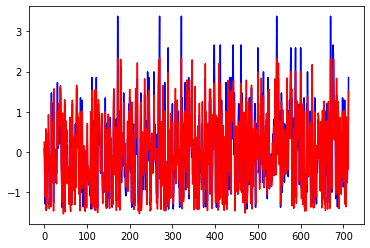

In [71]:
from sklearn.svm import SVR
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              # Regularization parameter. The strength of the regularization is inversely proportional to C. 
              # Must be strictly positive. The penalty is a squared l2 penalty.
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              # if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
              # if ‘auto’, uses 1 / n_features.
              
              'kernel': ['rbf']} 
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred)) 
print('Mean Absolute Percentage Error is:',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))


# Transfer Learning

MSE: 
 181852.6357030611

R2: 
 0.9181077253696447

MAPE: 
 0.16334893006610682


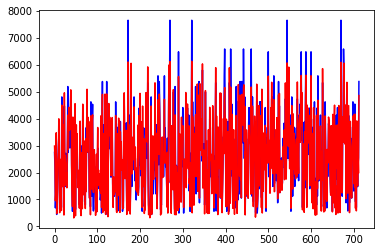

In [72]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.svm import SVR
best_svr = SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

best_svr.fit(X_train, Y_train)
Y_pred = best_svr.predict(X_test)
Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores[0])


# 2. Linear Regression + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] fit_intercept=True, normalize=True ..............................
[CV] . fit_intercept=True, normalize=True, score=-0.240, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................
[CV] .. fit_intercept=True, normalize=True, score=0.930, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] fit_intercept=True, normalize=True ..............................
[CV]  fit_intercept=True, normalize=True, score=-37572048521597588440862425088.000, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-0.246, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................
[CV] . fit_intercept=True, normalize=False, score=0.930, total=   0.0s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-5372683313239960024252416.000, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................
[CV]  fit_intercept=False, normalize=True, score=-0.237, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................
[CV] . fit_intercept=False, normalize=True, score=0.930, total=   0.0s
[CV] fit_intercept=False, normalize=True .............................
[CV]  fit_intercept=False,

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'fit_intercept': True, 'normalize': False}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MSE =  1.8600921509740746e+18
R2 score = -1.8600921509740746e+18

Mean Absolute Percentage Error = [-8.17420989e+08]
Mean Absolute Error is: 949519640.808124


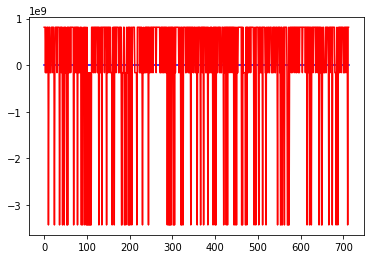

In [73]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
# defining parameter range 
param_grid = {'fit_intercept': [True, False],  
             'normalize' : [True, False], 
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# Transfer Learning

MSE: 
 4.1305808372286526e+24

R2: 
 -1.8600921509740744e+18

MAPE: 
 [8.85306305e+08]


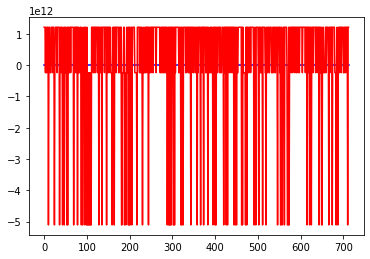

In [34]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.svm import SVR
best_lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
best_lr.fit(X_train, Y_train)
Y_pred = best_lr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)


In [35]:
X_train.shape, Y_train.shape

((1477, 21), (1477, 1))

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=-0.273, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=0.920, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=auto ......
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=auto, score=-72729265.274, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=-0.273, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=0.920, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=svd .......
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=svd, score=-80853843.833, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=-0.273, total=   0.0s
[CV] alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky ..
[CV]  alpha=0.1, fit_intercept=True, normalize=True, solver=cholesky, score=0.920, total= 

[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=-7.255, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........
[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=0.686, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=sag .........
[CV]  alpha=1, fit_intercept=True, normalize=True, solver=sag, score=-1988444303279898107370799104.000, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........
[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=-7.256, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........
[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=0.686, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=True, solver=saga ........
[CV]  alpha=1, fit_intercept=True, normalize=True, solver=saga, score=-9218647679794873145606799360.000, total=   0.0s
[CV] alpha=1, fit_intercept=True, normalize=

[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......
[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=-0.234, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......
[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.930, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=lsqr ......
[CV]  alpha=10, fit_intercept=True, normalize=False, solver=lsqr, score=0.675, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .
[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=-0.234, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .
[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.930, total=   0.0s
[CV] alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg .
[CV]  alpha=10, fit_intercept=True, normalize=False, solver=sparse_cg, score=0.675, total=   0.0s

[CV] alpha=100, fit_intercept=False, normalize=True, solver=auto .....
[CV]  alpha=100, fit_intercept=False, normalize=True, solver=auto, score=0.613, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......
[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=-0.157, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......
[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=0.922, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=svd ......
[CV]  alpha=100, fit_intercept=False, normalize=True, solver=svd, score=0.613, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .
[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=-0.157, total=   0.0s
[CV] alpha=100, fit_intercept=False, normalize=True, solver=cholesky .
[CV]  alpha=100, fit_intercept=False, normalize=True, solver=cholesky, score=0.922, total=   0.0s
[CV

[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=-3.791, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....
[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=0.716, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=sag .....
[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=sag, score=-0.452, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....
[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=-3.790, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....
[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=0.716, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=True, solver=saga ....
[CV]  alpha=1000, fit_intercept=False, normalize=True, solver=saga, score=-0.453, total=   0.0s
[CV] alpha=1000, fit_intercept=False, normalize=False, solver=auto ...
[CV

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    7.0s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 10, 'fit_intercept': False, 'normalize': False, 'solver': 'sag'}
Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='sag', tol=0.001)
MSE =  0.15421264546800653
R2 score = 0.8457873545319935

Mean Absolute Percentage Error = [-0.33715403]
Mean Absolute Error is: 0.3001828560579794


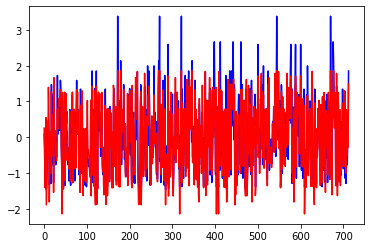

In [74]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=1.0, fit_intercept=True, 
                         normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# defining parameter range 
param_grid = {'alpha': [0.1, 1, 10, 100, 1000],  
             'fit_intercept' : [True, False],
              'normalize' :[True, False],
              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best RR

MSE: 
 343837.43287549395

R2: 
 0.8451623790198256

MAPE: 
 [0.23445695]


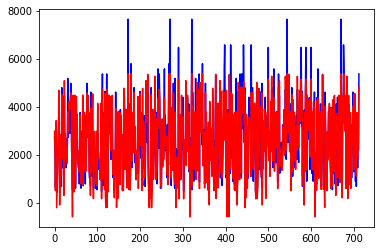

In [75]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn import linear_model
best_rr = linear_model.Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=None, solver='sag', tol=0.001)
best_rr.fit(X_train, Y_train)
Y_pred = best_rr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)


# 4. K-Nearest Neighbors + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_neighbors=2, p=1, weights=uniform .............................
[CV]  n_neighbors=2, p=1, weights=uniform, score=-7.739, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=2, p=1, weights=uniform .............................
[CV]  n_neighbors=2, p=1, weights=uniform, score=-0.646, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] n_neighbors=2, p=1, weights=uniform .............................
[CV]  n_neighbors=2, p=1, weights=uniform, score=-0.662, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=-7.741, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=-0.646, total=   0.0s
[CV] n_neighbors=2, p=1, weights=distance ............................
[CV]  n_neighbors=2, p=1, weights=distance, score=-0.662, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................
[CV]  n_neighbors=2, p=2, weights=uniform, score=-7.741, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................
[CV]  n_neighbors=2, p=2, weights=uniform, score=-0.647, total=   0.0s
[CV] n_neighbors=2, p=2, weights=uniform .............................
[CV]  n_neighbors=2, p=2, weights=uniform, score=-0.644, total=   0.0s
[CV

[CV] n_neighbors=5, p=2, weights=uniform .............................
[CV]  n_neighbors=5, p=2, weights=uniform, score=-1.014, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................
[CV]  n_neighbors=5, p=2, weights=distance, score=-8.829, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................
[CV]  n_neighbors=5, p=2, weights=distance, score=-0.203, total=   0.0s
[CV] n_neighbors=5, p=2, weights=distance ............................
[CV]  n_neighbors=5, p=2, weights=distance, score=-0.927, total=   0.0s
[CV] n_neighbors=5, p=4, weights=uniform .............................
[CV]  n_neighbors=5, p=4, weights=uniform, score=-7.935, total=   0.1s
[CV] n_neighbors=5, p=4, weights=uniform .............................
[CV]  n_neighbors=5, p=4, weights=uniform, score=-0.556, total=   0.1s
[CV] n_neighbors=5, p=4, weights=uniform .............................
[CV]  n_neighbors=5, p=4, weights=uniform, score=-0.830, total=   0.2s
[CV

[CV] n_neighbors=9, p=4, weights=uniform .............................
[CV]  n_neighbors=9, p=4, weights=uniform, score=-1.109, total=   0.2s
[CV] n_neighbors=9, p=4, weights=distance ............................
[CV]  n_neighbors=9, p=4, weights=distance, score=-8.082, total=   0.1s
[CV] n_neighbors=9, p=4, weights=distance ............................
[CV]  n_neighbors=9, p=4, weights=distance, score=-0.154, total=   0.2s
[CV] n_neighbors=9, p=4, weights=distance ............................
[CV]  n_neighbors=9, p=4, weights=distance, score=-1.021, total=   0.2s
[CV] n_neighbors=9, p=5, weights=uniform .............................
[CV]  n_neighbors=9, p=5, weights=uniform, score=-7.988, total=   0.1s
[CV] n_neighbors=9, p=5, weights=uniform .............................
[CV]  n_neighbors=9, p=5, weights=uniform, score=-0.257, total=   0.2s
[CV] n_neighbors=9, p=5, weights=uniform .............................
[CV]  n_neighbors=9, p=5, weights=uniform, score=-1.074, total=   0.2s
[CV

[CV] n_neighbors=15, p=5, weights=uniform ............................
[CV]  n_neighbors=15, p=5, weights=uniform, score=-1.267, total=   0.3s
[CV] n_neighbors=15, p=5, weights=distance ...........................
[CV]  n_neighbors=15, p=5, weights=distance, score=-8.456, total=   0.2s
[CV] n_neighbors=15, p=5, weights=distance ...........................
[CV]  n_neighbors=15, p=5, weights=distance, score=0.044, total=   0.2s
[CV] n_neighbors=15, p=5, weights=distance ...........................
[CV]  n_neighbors=15, p=5, weights=distance, score=-1.170, total=   0.2s
[CV] n_neighbors=15, p=7, weights=uniform ............................
[CV]  n_neighbors=15, p=7, weights=uniform, score=-8.455, total=   0.1s
[CV] n_neighbors=15, p=7, weights=uniform ............................
[CV]  n_neighbors=15, p=7, weights=uniform, score=-0.069, total=   0.2s
[CV] n_neighbors=15, p=7, weights=uniform ............................
[CV]  n_neighbors=15, p=7, weights=uniform, score=-1.232, total=   0.

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   44.6s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 10, 'p': 7, 'weights': 'distance'}
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=7,
                    weights='distance')
MSE =  0.2693804089276725
R2 score = 0.7306195910723274

Mean Absolute Percentage Error = [-0.14200033]
Mean Absolute Error is: 0.3598726491227892


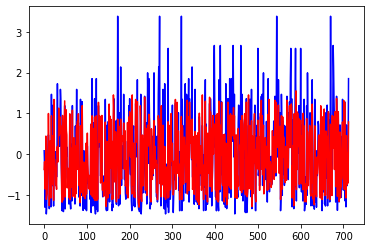

In [39]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5, weights='uniform', 
                            algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
# defining parameter range 
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 9, 10, 13, 15],  
             'weights' : ['uniform', 'distance'],
              'p' : [1, 2, 4, 5, 7 ,10]
             } 
grid = GridSearchCV(neigh, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best KNN Regressor

MSE: 
 847904.8598117287

R2: 
 0.6181696384456299

MAPE: 
 0.2328874230123312


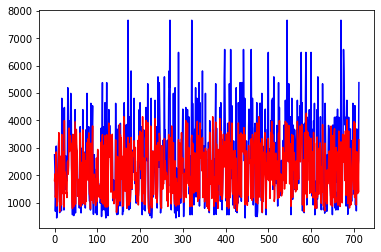

In [109]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.neighbors import KNeighborsRegressor
best_knn = KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=7,
                    weights='distance')
best_knn.fit(X_train, Y_train)
Y_pred = best_knn.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)

# 5. Gaussian Process Regressor (Marcov Chain Monte Carlo) + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-10, normalize_y=True ...................................
[CV] ...... alpha=1e-10, normalize_y=True, score=-6.842, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=1e-10, normalize_y=True ...................................
[CV] ....... alpha=1e-10, normalize_y=True, score=0.981, total=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] alpha=1e-10, normalize_y=True ...................................
[CV] ...... alpha=1e-10, normalize_y=True, score=-0.266, total=   0.2s
[CV] alpha=1e-10, normalize_y=False ..................................
[CV] ..... alpha=1e-10, normalize_y=False, score=-3.573, total=   0.2s
[CV] alpha=1e-10, normalize_y=False ..................................
[CV] ...... alpha=1e-10, normalize_y=False, score=0.980, total=   0.2s
[CV] alpha=1e-10, normalize_y=False ..................................
[CV] ...... alpha=1e-10, normalize_y=False, score=0.254, total=   0.2s
[CV] alpha=1e-09, normalize_y=True ...................................
[CV] ...... alpha=1e-09, normalize_y=True, score=-6.842, total=   0.2s
[CV] alpha=1e-09, normalize_y=True ...................................
[CV] ....... alpha=1e-09, normalize_y=True, score=0.981, total=   0.2s
[CV] alpha=1e-09, normalize_y=True ...................................
[CV] ...... alpha=1e-09, normalize_y=True, score=-0.266, total=   0.2s
[CV] a

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.9s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 1e-10, 'normalize_y': False}
GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
MSE =  0.7909224819465224
R2 score = 0.20907751805347763

Mean Absolute Percentage Error = [-0.09214255]
Mean Absolute Error is: 0.7115159339434552


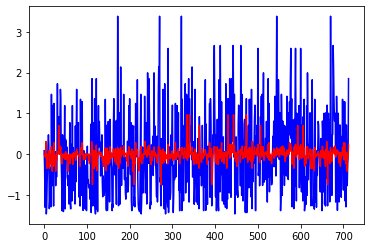

In [40]:
from sklearn.gaussian_process import GaussianProcessRegressor
gpr = GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0 , 
                               normalize_y= True, copy_X_train=True, random_state= None)
# defining parameter range 
param_grid = {'alpha': [1e-10, 1e-9, 1e-5, 1e-2],  
             'normalize_y' : [True, False],
                         } 
grid = GridSearchCV(gpr, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best Gaussian Process Regressor

MSE: 
 1756348.0636971756

R2: 
 0.20907751805347774

MAPE: 
 [0.70009461]


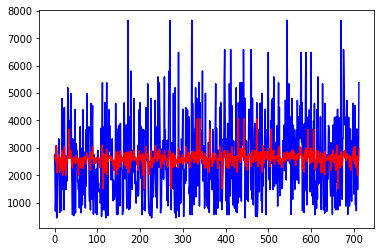

In [28]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.gaussian_process import GaussianProcessRegressor
best_gpr =GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)
best_gpr.fit(X_train, Y_train)
Y_pred = best_gpr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)

# 6. Decision Tree + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 1260 candidates, totalling 3780 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=-7.415, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=-1.699, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=best, score=-2.174, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=-13.521, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=-5.452, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.971, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=2, splitter=best, 

[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-30.433, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-5.670, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-6.027, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best, score=-14.054, total=   0.0s
[CV] criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=2, max_features=log2, min_samples_leaf=1, splitter=best,

[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 
[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=-3.104, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random 
[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=6, splitter=random, score=-0.932, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 
[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=-7.253, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 
[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score=-1.447, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best 
[CV]  criterion=mse, max_depth=3, max_features=auto, min_samples_leaf=7, splitter=best, score

[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random 
[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=5, splitter=random, score=-6.014, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=-13.852, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.008, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=best, score=-2.583, total=   0.0s
[CV] criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random 
[CV]  criterion=mse, max_depth=3, max_features=log2, min_samples_leaf=6, splitter=random, scor

[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 
[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-11.728, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 
[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-1.298, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best 
[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-1.182, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-30.435, total=   0.0s
[CV] criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=mse, max_depth=4, max_features=sqrt, min_samples_leaf=5, splitter=random, sco

[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.641, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.643, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=-7.219, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, score=-3.478, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=5, max_features=auto, min_samples_leaf=4, splitter=random, s

[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best 
[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=best, score=-1.646, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 
[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-20.048, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 
[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-3.989, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 
[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-4.783, total=   0.0s
[CV] criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, 

[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 
[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-13.252, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 
[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-5.404, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 
[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random, score=-1.749, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 
[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best, score=-12.119, total=   0.0s
[CV] criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best 
[CV]  criterion=mse, max_depth=7, max_features=sqrt, min_samples_leaf=3, splitter=best,

[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.129, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.612, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=-3.971, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.495, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=mse, max_depth=9, max_features=auto, min_samples_leaf=2, splitter=best, score

[CV] criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=mse, max_depth=9, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-1.448, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=-11.348, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=-2.021, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=best, score=-1.999, total=   0.0s
[CV] criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random 
[CV]  criterion=mse, max_depth=9, max_features=log2, min_samples_leaf=1, splitter=random, scor

[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 
[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=-7.294, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 
[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.630, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best 
[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=best, score=-0.640, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 
[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random, score=-7.248, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=random 
[CV]  criterion=mse, max_depth=10, max_features=auto, min_samples_leaf=7, splitter=ran

[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-7.528, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-0.433, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=best, score=-2.566, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 
[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=-26.495, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random 
[CV]  criterion=mse, max_depth=10, max_features=log2, min_samples_leaf=6, splitter=random, score=-3.416, total=   0.0s
[CV] criterion=mse, max_depth=10, max_features=log2, m

[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-3.159, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best 
[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-1.230, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-30.037, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-2.276, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=mse, max_depth=15, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-2.207, total=   0.0s
[CV] criterion=mse, max_depth=15, max_features=sqr

[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.634, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=best, score=-0.596, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=-7.383, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.655, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=20, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.595, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=auto

[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 
[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-1.533, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-7.725, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.720, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-1.876, total=   0.0s
[CV] criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=random 
[CV]  criterion=mse, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=ran

[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.595, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-3.944, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.492, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.595, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=mse, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=random, score=-7.672, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=auto, min_

[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-7.879, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 
[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-1.204, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 
[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.898, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-13.580, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-3.219, total=   0.0s
[CV] criterion=mse, max_depth=30, max_features=log2, m

[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 
[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=-3.510, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random 
[CV]  criterion=friedman_mse, max_depth=2, max_features=auto, min_samples_leaf=7, splitter=random, score=-4.042, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 
[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-13.554, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 
[CV]  criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=0.277, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 
[CV]  criter

[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random 
[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=5, splitter=random, score=-5.899, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-30.149, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=0.014, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best 
[CV]  criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=best, score=-6.016, total=   0.0s
[CV] criterion=friedman_mse, max_depth=2, max_features=log2, min_samples_leaf=6, splitter=random 
[CV]  criterio

[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-10.734, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-3.425, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-4.972, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 
[CV]  criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-1.126, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, max_features=sqrt, min_samples_leaf=4, splitter=random 
[CV]  criteri

[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.688, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=best, score=-0.696, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 
[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=-1.136, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 
[CV]  criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.879, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=auto, min_samples_leaf=2, splitter=random 
[CV]  crit

[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-5.605, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-28.277, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-0.277, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random 
[CV]  criterion=friedman_mse, max_depth=4, max_features=sqrt, min_samples_leaf=7, splitter=random, score=-1.442, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  c

[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 
[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=-7.667, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 
[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.810, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random 
[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.664, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best, score=-7.195, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  cr

[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-0.891, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=3, splitter=random, score=-1.314, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 
[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=-13.505, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 
[CV]  criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best, score=-1.621, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, max_features=log2, min_samples_leaf=4, splitter=best 
[CV]  crite

[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-2.685, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 
[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-15.509, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 
[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best 
[CV]  criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-2.576, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=sqrt, min_samples_leaf=2, splitter=random 
[CV]  criteri

[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 
[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=-15.044, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 
[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=-0.888, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best 
[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=best, score=-2.987, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random, score=-21.626, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criter

[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 
[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-1.137, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best 
[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=best, score=-1.471, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-9.728, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random, score=-1.132, total=   0.0s
[CV] criterion=friedman_mse, max_depth=9, max_features=sqrt, min_samples_leaf=5, splitter=random 
[CV]  crit

[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.595, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=-4.543, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=-3.123, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.603, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=auto, min_samples_leaf=4, splitter=best 

[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best 
[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=best, score=-1.546, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.931, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=-1.642, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=1, splitter=random, score=-2.390, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, max_features=log2, min_samples_leaf=2, splitter=best 

[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.601, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.971, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random 
[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-1.339, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-8.460, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, max_features=sqrt, min_samples_leaf=4, splitter=best 

[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=-2.850, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.149, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random 
[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=1, splitter=random, score=-0.642, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 
[CV]  criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best, score=-3.949, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=auto, min_samples_leaf=2, splitter=best 

[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-15.723, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-5.376, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-3.156, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-11.553, total=   0.0s
[CV] criterion=friedman_mse, max_depth=20, max_features=sqrt, min_samples_leaf=7, splitter=bes

[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=-7.612, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=-3.088, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random 
[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=4, splitter=random, score=-0.578, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 
[CV]  criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best, score=-7.672, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=auto, min_samples_leaf=5, splitter=best 

[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-9.591, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-2.401, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-0.868, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best 
[CV]  criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best, score=-12.035, total=   0.0s
[CV] criterion=friedman_mse, max_depth=30, max_features=log2, min_samples_leaf=3, splitter=best

[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 
[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-2.404, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best 
[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=best, score=-5.695, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-30.263, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.342, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=mae, max_depth=2, max_features=sqrt, min_samples_leaf=1, splitter=random, 

[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best 
[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=best, score=-4.692, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-18.239, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-0.242, total=   0.0s
[CV] criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criterion=mae, max_depth=2, max_features=log2, min_samples_leaf=7, splitter=random, score=-6.800, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mae, max_depth=3, max_features=auto, min_samples_leaf=1, splitter=best, 

[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-27.750, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-1.479, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-5.679, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-20.091, total=   0.0s
[CV] criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=mae, max_depth=3, max_features=sqrt, min_samples_leaf=7, splitter=best,

[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 
[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=-3.348, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random 
[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=5, splitter=random, score=-1.742, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=-8.004, total=   0.1s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.693, total=   0.1s
[CV] criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=mae, max_depth=4, max_features=auto, min_samples_leaf=6, splitter=best, score

[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random 
[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=4, splitter=random, score=-2.874, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 
[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=-31.771, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 
[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=-0.317, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best 
[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=best, score=-4.999, total=   0.0s
[CV] criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random 
[CV]  criterion=mae, max_depth=4, max_features=log2, min_samples_leaf=5, splitter=random, scor

[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-9.897, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-0.709, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-2.896, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 
[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, score=-27.909, total=   0.0s
[CV] criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random 
[CV]  criterion=mae, max_depth=5, max_features=sqrt, min_samples_leaf=4, splitter=random, scor

[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.617, total=   0.1s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.596, total=   0.1s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=-0.544, total=   0.1s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, score=-2.732, total=   0.1s
[CV] criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random 
[CV]  criterion=mae, max_depth=7, max_features=auto, min_samples_leaf=3, splitter=random, s

[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best 
[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=best, score=-1.914, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-14.883, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-4.283, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=2, splitter=random, score=-3.765, total=   0.0s
[CV] criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best 
[CV]  criterion=mae, max_depth=7, max_features=log2, min_samples_leaf=3, splitter=best, 

[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-13.327, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.715, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random 
[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=1, splitter=random, score=-0.742, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 
[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, score=-6.622, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best 
[CV]  criterion=mae, max_depth=9, max_features=sqrt, min_samples_leaf=2, splitter=best, 

[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-4.456, total=   0.0s
[CV] criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random 
[CV]  criterion=mae, max_depth=9, max_features=log2, min_samples_leaf=7, splitter=random, score=-4.429, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=-4.977, total=   0.1s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best, score=-0.520, total=   0.1s
[CV] criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best 
[CV]  criterion=mae, max_depth=10, max_features=auto, min_samples_leaf=1, splitter=best,

[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-0.749, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random 
[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=6, splitter=random, score=-3.618, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-9.194, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-1.428, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best 
[CV]  criterion=mae, max_depth=10, max_features=sqrt, min_samples_leaf=7, splitter=best, score=-2.168, total=   0.0s
[CV] criterion=mae, max_depth=10, max_features=sqrt, min_

[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.649, total=   0.1s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random 
[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=5, splitter=random, score=-0.585, total=   0.1s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=-7.685, total=   0.1s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.659, total=   0.1s
[CV] criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best 
[CV]  criterion=mae, max_depth=15, max_features=auto, min_samples_leaf=6, splitter=best, score=-0.637, total=   0.2s
[CV] criterion=mae, max_depth=15, max_features=auto, min_

[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=-1.635, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random 
[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=4, splitter=random, score=-1.211, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 
[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=-16.014, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 
[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=-1.273, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best 
[CV]  criterion=mae, max_depth=15, max_features=log2, min_samples_leaf=5, splitter=best, score=-3.436, total=   0.0s
[CV] criterion=mae, max_depth=15, max_features=log2, min

[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-2.634, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random 
[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=3, splitter=random, score=-0.873, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-7.667, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-1.172, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best 
[CV]  criterion=mae, max_depth=20, max_features=sqrt, min_samples_leaf=4, splitter=best, score=-1.667, total=   0.0s
[CV] criterion=mae, max_depth=20, max_features=sqrt, min_

[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.526, total=   0.1s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random 
[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=2, splitter=random, score=-0.600, total=   0.1s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-4.960, total=   0.1s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.623, total=   0.1s
[CV] criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best 
[CV]  criterion=mae, max_depth=30, max_features=auto, min_samples_leaf=3, splitter=best, score=-0.595, total=   0.1s
[CV] criterion=mae, max_depth=30, max_features=auto, min_

[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=1, splitter=random, score=-0.654, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 
[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-7.997, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 
[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-0.134, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best 
[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=best, score=-3.236, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random 
[CV]  criterion=mae, max_depth=30, max_features=log2, min_samples_leaf=2, splitter=random, score=-2.629, total=   0.0s
[CV] criterion=mae, max_depth=30, max_features=log2, min_

[Parallel(n_jobs=1)]: Done 3780 out of 3780 | elapsed:  1.3min finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'friedman_mse', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 3, 'splitter': 'random'}
DecisionTreeRegressor(criterion='friedman_mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=None, splitter='random')
MSE =  0.1424680520863918
R2 score = 0.8575319479136082

Mean Absolute Percentage Error = [-0.27817537]
Mean Absolute Error is: 0.27532173422175593


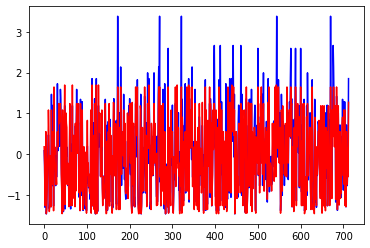

In [41]:
from sklearn.tree import DecisionTreeRegressor #  ' min_samples_split' : [2],
regressor = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, 
                                  min_samples_split=2,
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                                  max_features=None, random_state=None, max_leaf_nodes=None, 
                                  min_impurity_decrease=0.0, min_impurity_split=None)
# defining parameter range 
param_grid = {'criterion': ['mse','friedman_mse', 'mae'],  
              'splitter' : ['best', 'random'], 
              'max_depth': [2,3,4,5,7,9,10,15,20,30 ],
              'min_samples_leaf' : [1, 2,3,  4, 5,6, 7],
              'max_features' : ['auto', 'sqrt', 'log2'],
             } 
grid = GridSearchCV(regressor, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best Decision Tree Regressor 

MSE: 
 387253.1222852174

R2: 
 0.8256113312900982

MAPE: 
 [0.16473489]


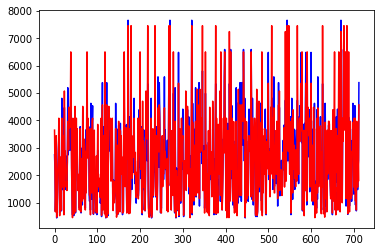

In [29]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.tree import DecisionTreeRegressor
best_dtr = DecisionTreeRegressor(criterion='friedman_mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=None, splitter='random')
best_dtr.fit(X_train, Y_train)
Y_pred = best_dtr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)

# 7. Random Forest + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-6.102, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-0.755, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-0.980, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=-7.218, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.130, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=-0.934, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=-6.982, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.105, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=-0.930, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=-7.136, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.122, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=-0.934, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=-7.091, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.125, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=-0.926, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=-6.851, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.095, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=-0.945, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=-7.141, total=   0.5s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.122, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=-0.927, total=   0.5s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=-7.110, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.075, total=   0.4s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=-0.934, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=-4.461, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.031, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.686, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=-5.295, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.041, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.706, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=-4.660, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.190, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=-0.700, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=-4.847, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.187, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=-0.698, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=-4.729, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.204, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=-0.694, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=-4.597, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.198, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=-0.701, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=-4.922, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.168, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=-0.695, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=-4.575, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.198, total=   0.4s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=-0.700, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=-3.753, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.153, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.659, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=-4.138, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.295, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.652, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=-4.182, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.332, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=-0.648, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=-4.358, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.353, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=-0.648, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=-4.169, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.341, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=-0.650, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=-3.927, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.356, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=-0.652, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=-4.441, total=   0.5s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.366, total=   0.5s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=-0.652, total=   0.5s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=-4.462, total=   0.5s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.327, total=   0.5s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=-0.652, total=   0.5s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=-3.493, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.368, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.585, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=-4.711, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.218, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.589, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=-4.170, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.401, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.588, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=-3.899, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.401, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.592, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=-4.417, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.430, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=-0.592, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=-4.154, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.385, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=-0.588, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=-4.452, total=   0.6s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.405, total=   0.6s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=-0.591, total=   0.6s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=-4.264, total=   0.6s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.407, total=   0.6s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=-0.591, total=   0.6s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=-4.366, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.189, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.588, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=-2.885, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.200, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.585, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=-4.112, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.452, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.588, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=-4.628, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.380, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.589, total=   0.2s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=-4.241, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.412, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=-0.589, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=-3.918, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.392, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=-0.590, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=-4.165, total=   0.7s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.356, total=   0.7s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=-0.589, total=   0.7s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=-4.415, total=   0.7s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.350, total=   0.7s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=-0.589, total=   0.7s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=-5.172, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.465, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.591, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=-4.299, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.257, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.590, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=-4.478, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.403, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.591, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=-4.166, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.344, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.587, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=-4.209, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.412, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=-0.587, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=-4.356, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.431, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=-0.590, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=-4.217, total=   0.7s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.339, total=   0.7s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=-0.588, total=   0.7s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=-4.554, total=   0.7s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.406, total=   0.7s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=-0.587, total=   0.7s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=-4.876, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.416, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.586, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=-4.238, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.317, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.587, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=-4.719, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.370, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.591, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=-5.074, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.394, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.590, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=-3.927, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.431, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=-0.589, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=-4.390, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.398, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=-0.586, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=-4.381, total=   0.7s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.418, total=   0.7s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=-0.587, total=   0.7s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=-4.311, total=   0.7s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.394, total=   0.7s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=-0.591, total=   0.7s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=-7.252, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.123, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=-0.945, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=-7.117, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=-0.286, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=-0.963, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=-6.957, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.078, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=-0.941, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=-7.201, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.108, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=-0.921, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=-6.893, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.096, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=-0.926, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=-7.044, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.104, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=-0.927, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=-7.031, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.114, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=-0.934, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=-6.927, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.090, total=   0.4s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=-0.937, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=-5.198, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.019, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.701, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=-4.126, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.179, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.699, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=-5.098, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.189, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=-0.702, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=-5.162, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.157, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=-0.692, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=-4.885, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.193, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=-0.695, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=-4.892, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.195, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=-0.703, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=-4.914, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.163, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=-0.697, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=-5.011, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.191, total=   0.4s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=-0.698, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=-4.097, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.232, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.635, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=-4.938, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.170, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.650, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=-4.281, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.354, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=-0.648, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=-4.273, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.299, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=-0.644, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=-4.489, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.324, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=-0.648, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=-4.578, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.384, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=-0.650, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=-4.373, total=   0.5s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.370, total=   0.5s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=-0.648, total=   0.5s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=-4.457, total=   0.5s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.270, total=   0.6s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=-0.649, total=   0.5s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=-3.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.213, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.588, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=-3.994, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.343, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.585, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=-4.485, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.269, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.589, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=-4.333, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.410, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.593, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=-4.217, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.394, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=-0.590, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=-4.638, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.445, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=-0.590, total=   0.3s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=-4.243, total=   0.6s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.385, total=   0.6s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=-0.589, total=   0.6s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=-4.488, total=   0.6s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.391, total=   0.6s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=-0.591, total=   0.6s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=-3.746, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.450, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.585, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=-3.297, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.035, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.591, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=-4.100, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.412, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.588, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=-4.228, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.417, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.587, total=   0.2s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=-4.300, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.418, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=-0.589, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=-4.400, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.412, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=-0.589, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=-4.141, total=   0.7s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.426, total=   0.7s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=-0.588, total=   0.6s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=-4.554, total=   0.7s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.421, total=   0.7s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=-0.589, total=   0.7s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=-4.290, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.326, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.594, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=-4.032, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.336, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.585, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=-4.743, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.443, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.593, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=-4.154, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.361, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.587, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=-4.193, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.361, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=-0.588, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=-4.596, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.380, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=-0.589, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=-4.372, total=   0.7s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.383, total=   0.7s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=-0.587, total=   0.7s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=-4.392, total=   0.7s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.407, total=   0.7s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=-0.588, total=   0.6s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=-3.763, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.234, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.594, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=-4.707, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.293, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.589, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=-4.203, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.365, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.591, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=-3.968, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.367, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.586, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=-4.616, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.383, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=-0.587, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=-4.429, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.411, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=-0.587, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=-4.190, total=   0.7s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.413, total=   0.7s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=-0.589, total=   0.7s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=-4.487, total=   0.7s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.423, total=   0.7s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=-0.587, total=   0.7s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=-6.961, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=-0.062, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=-1.119, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=-6.971, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.036, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=-1.107, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=-6.977, total=   1.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=-0.081, total=   1.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=-1.107, total=   1.2s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=-6.948, total=   1.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.168, total=   1.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=-1.111, total=   1.2s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=-6.955, total=   2.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.114, total=   2.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=-1.113, total=   2.4s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=-6.959, total=   2.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.076, total=   2.5s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=-1.122, total=   2.4s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=-6.952, total=   5.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.167, total=   5.6s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=-1.112, total=   5.7s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=-6.958, total=   5.0s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.160, total=   5.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=-1.108, total=   5.1s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=-7.582, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.163, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=-0.707, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=-6.128, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.567, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=-0.712, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=-5.961, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.128, total=   1.5s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=-0.716, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=-6.334, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.170, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=-0.710, total=   1.4s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=-6.958, total=   2.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.311, total=   2.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=-0.706, total=   2.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=-6.440, total=   2.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.274, total=   2.8s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=-0.713, total=   2.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=-6.470, total=   5.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.230, total=   6.0s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=-0.720, total=   5.6s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=-6.503, total=   5.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.292, total=   5.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=-0.711, total=   5.5s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=-4.980, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.600, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=-0.688, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=-6.174, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.196, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=-0.660, total=   0.3s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=-5.567, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.445, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=-0.684, total=   1.5s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=-4.865, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.258, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=-0.696, total=   1.5s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=-5.198, total=   3.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.364, total=   3.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=-0.672, total=   3.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=-5.168, total=   3.1s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.329, total=   3.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=-0.687, total=   3.0s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=-5.107, total=   6.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.377, total=   6.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=-0.688, total=   5.9s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=-5.143, total=   6.0s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.301, total=   6.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=-0.689, total=   5.9s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=-4.828, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.244, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=-0.590, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=-5.770, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.302, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=-0.605, total=   0.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=-4.673, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.382, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=-0.598, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=-5.324, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.500, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=-0.595, total=   1.7s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=-5.116, total=   3.5s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.418, total=   3.6s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=-0.597, total=   3.4s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=-4.895, total=   3.6s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.329, total=   3.6s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=-0.593, total=   3.4s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=-5.026, total=   7.0s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.392, total=   7.1s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=-0.594, total=   6.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=-4.900, total=   8.1s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.447, total=   7.1s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=-0.594, total=   6.8s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=-5.206, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.198, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=-0.595, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=-5.261, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.333, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=-0.580, total=   0.4s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=-5.199, total=   1.9s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.361, total=   1.9s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=-0.588, total=   1.8s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=-5.453, total=   1.9s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.439, total=   1.9s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=-0.590, total=   1.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=-4.945, total=   3.7s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.486, total=   3.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=-0.588, total=   3.6s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=-4.965, total=   3.8s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.407, total=   3.7s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=-0.588, total=   3.7s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=-5.002, total=   7.4s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.378, total=   7.5s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=-0.587, total=   7.3s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=-5.040, total=   7.5s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.378, total=   7.7s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=-0.587, total=   7.3s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=-4.130, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.312, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=-0.586, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=-4.465, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.265, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=-0.589, total=   0.4s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=-4.808, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.244, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=-0.588, total=   1.8s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=-5.042, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.299, total=   1.9s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=-0.590, total=   1.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=-5.141, total=   3.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.432, total=   3.7s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=-0.588, total=   3.7s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=-5.251, total=   3.7s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.417, total=   3.8s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=-0.588, total=   3.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=-5.076, total=   7.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.338, total=   7.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=-0.589, total=   7.4s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=-5.100, total=   7.5s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.396, total=   7.5s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=-0.587, total=   7.2s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=-5.411, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.281, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=-0.590, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=-5.557, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.303, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=-0.592, total=   0.4s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=-4.718, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.337, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=-0.587, total=   1.8s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=-5.143, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.420, total=   1.9s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=-0.589, total=   1.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=-5.029, total=   3.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.330, total=   3.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=-0.591, total=   3.7s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=-4.909, total=   3.8s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.324, total=   3.9s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=-0.588, total=   3.7s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=-4.591, total=   7.5s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.363, total=   7.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=-0.588, total=   7.2s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=-4.953, total=   7.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.388, total=   7.5s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=-0.587, total=   7.8s


[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed:  9.8min finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
0it [00:00, ?it/s]


{'criterion': 'mse', 'max_depth': 10, 'n_estimators': 10, 'warm_start': 'False'}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start='False')
MSE =  0.1198911971333195
R2 score = 0.8801088028666805

Mean Absolute Percentage Error = [-0.23917248]
Mean Absolute Error is: 0.2715257689413692


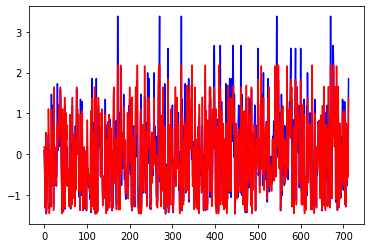

In [42]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, 
                            min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                            max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
                            bootstrap=True, oob_score=False, n_jobs=None, random_state=None, 
                            verbose=0, warm_start=False)
# defining parameter range 
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'warm_start': ['True', 'False'],

             } 
'''
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'max_leaf_nodes' : [None, 10, 50, 100, 200], 
              'warm_start': ['True', 'False'],
              
             }'''
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
tqdm(grid.fit(X_train, Y_train)) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best Random Forest

MSE: 
 264206.8304508315

R2: 
 0.8810218051839267

MAPE: 
 [0.15652132]


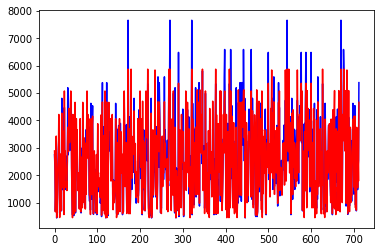

In [30]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.ensemble import RandomForestRegressor
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start='False')
best_rf.fit(X_train, Y_train)
Y_pred = best_rf.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)

# 8. Extrememly Randomized Trees + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 168 candidates, totalling 504 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-3.297, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=0.489, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=True, score=-1.106, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=-3.297, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=0.489, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=10, warm_start=False, score=-1.106, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=-4.613, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=0.622, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=True, score=-1.086, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=-4.613, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=0.622, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=50, warm_start=False, score=-1.086, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=-5.210, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=0.712, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=True, score=-1.107, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=-5.210, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=0.712, total=   0.2s
[CV] criterion=mse, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=100, warm_start=False, score=-1.107, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=-5.077, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=0.723, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=True, score=-1.188, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=-5.077, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=0.723, total=   0.3s
[CV] criterion=mse, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=3, n_estimators=200, warm_start=False, score=-1.188, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.960, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=0.686, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.724, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.960, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=0.686, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.724, total=   0.0s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=-1.834, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=0.904, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=True, score=-0.794, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=-1.834, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=0.904, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=50, warm_start=False, score=-0.794, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=-2.954, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=0.917, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=True, score=-0.800, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=-2.954, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=0.917, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=100, warm_start=False, score=-0.800, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=-2.717, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=0.923, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=True, score=-0.826, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=-2.717, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=0.923, total=   0.3s
[CV] criterion=mse, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=4, n_estimators=200, warm_start=False, score=-0.826, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.096, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.682, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.096, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=0.722, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.682, total=   0.0s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=-1.054, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=0.934, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=True, score=-0.665, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=-1.054, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=0.934, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=50, warm_start=False, score=-0.665, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=-1.550, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=0.947, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=True, score=-0.663, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=-1.550, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=0.947, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=100, warm_start=False, score=-0.663, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=-1.536, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=0.965, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=True, score=-0.671, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=-1.536, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=0.965, total=   0.4s
[CV] criterion=mse, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=5, n_estimators=200, warm_start=False, score=-0.671, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.043, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.613, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.043, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=0.889, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.613, total=   0.0s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.772, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=0.875, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.608, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.772, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=0.875, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.608, total=   0.1s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=-1.203, total=   0.3s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=0.950, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=True, score=-0.604, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=-1.203, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=0.950, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=100, warm_start=False, score=-0.604, total=   0.2s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=-1.057, total=   0.5s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=0.956, total=   0.5s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=True, score=-0.606, total=   0.5s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=-1.057, total=   0.5s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=0.956, total=   0.4s
[CV] criterion=mse, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=7, n_estimators=200, warm_start=False, score=-0.606, total=   0.4s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.030, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=0.830, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.605, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.030, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=0.830, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.605, total=   0.0s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.806, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=0.873, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.602, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.806, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=0.873, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.602, total=   0.1s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=-1.191, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=0.927, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=True, score=-0.597, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=-1.191, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=0.927, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=100, warm_start=False, score=-0.597, total=   0.3s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=-1.064, total=   0.6s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=0.961, total=   0.6s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=True, score=-0.600, total=   0.6s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=-1.064, total=   0.6s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=0.961, total=   0.6s
[CV] criterion=mse, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=10, n_estimators=200, warm_start=False, score=-0.600, total=   0.5s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.006, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.600, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.006, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.600, total=   0.0s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.799, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=0.887, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.601, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.799, total=   0.2s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=0.887, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.601, total=   0.1s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=-1.186, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=0.955, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=True, score=-0.600, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=-1.186, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=0.955, total=   0.3s
[CV] criterion=mse, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=100, warm_start=False, score=-0.600, total=   0.4s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=-1.061, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=0.964, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=True, score=-0.600, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=-1.061, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=0.964, total=   0.6s
[CV] criterion=mse, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=15, n_estimators=200, warm_start=False, score=-0.600, total=   0.6s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.006, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.600, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.006, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=0.729, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.600, total=   0.0s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.799, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=0.886, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.601, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.799, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=0.886, total=   0.2s
[CV] criterion=mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.601, total=   0.1s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=-1.186, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=0.955, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=True, score=-0.600, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=-1.186, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=0.955, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=100, warm_start=False, score=-0.600, total=   0.3s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=-1.061, total=   0.6s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=0.964, total=   0.6s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=True, score=-0.600, total=   0.6s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=-1.061, total=   0.8s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=0.964, total=   0.6s
[CV] criterion=mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mse, max_depth=None, n_estimators=200, warm_start=False, score=-0.600, total=   0.6s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=-3.297, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=0.489, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=True, score=-1.106, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=-3.297, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=0.489, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=10, warm_start=False, score=-1.106, total=   0.0s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=-4.613, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=0.622, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=True, score=-1.086, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=-4.613, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=0.622, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=50, warm_start=False, score=-1.086, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=-5.210, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=0.712, total=   0.1s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=True, score=-1.107, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=-5.210, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=0.712, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=100, warm_start=False, score=-1.107, total=   0.2s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=-5.075, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=0.723, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=True, score=-1.188, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=-5.075, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=0.723, total=   0.3s
[CV] criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=3, n_estimators=200, warm_start=False, score=-1.188, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=True, score=-0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.960, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=0.741, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=10, warm_start=False, score=-0.724, total=   0.0s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=-1.740, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=0.913, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=True, score=-0.794, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=-1.740, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=0.913, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=50, warm_start=False, score=-0.794, total=   0.1s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=-2.899, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=0.920, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=True, score=-0.800, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=-2.899, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=0.920, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=100, warm_start=False, score=-0.800, total=   0.2s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=-2.690, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=0.925, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=True, score=-0.826, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=-2.690, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=0.925, total=   0.3s
[CV] criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=4, n_estimators=200, warm_start=False, score=-0.826, total=   0.3s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.096, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=True, score=-0.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.096, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=0.753, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, warm_start=False, score=-0.682, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=-0.993, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=0.916, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=True, score=-0.665, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=-0.993, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=0.916, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, warm_start=False, score=-0.665, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=-1.519, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=0.940, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=True, score=-0.662, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=-1.519, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=0.940, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=100, warm_start=False, score=-0.662, total=   0.2s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=-1.523, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=0.963, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=True, score=-0.670, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=-1.523, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=0.963, total=   0.4s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=5, n_estimators=200, warm_start=False, score=-0.670, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.044, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=True, score=-0.606, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.044, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=0.863, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=10, warm_start=False, score=-0.606, total=   0.0s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.713, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=0.801, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=True, score=-0.607, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.713, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=0.801, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=50, warm_start=False, score=-0.607, total=   0.1s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=-1.171, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=0.929, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=True, score=-0.603, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=-1.171, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=0.929, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=100, warm_start=False, score=-0.603, total=   0.2s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=-1.045, total=   0.5s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=0.943, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=True, score=-0.605, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=-1.045, total=   0.5s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=0.943, total=   0.4s
[CV] criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=7, n_estimators=200, warm_start=False, score=-0.605, total=   0.4s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.007, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=0.813, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=True, score=-0.600, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.007, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=0.813, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=10, warm_start=False, score=-0.600, total=   0.0s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.739, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=0.932, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=True, score=-0.602, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.739, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=0.932, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=50, warm_start=False, score=-0.602, total=   0.1s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=-1.156, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=0.952, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=True, score=-0.599, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=-1.156, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=0.952, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=100, warm_start=False, score=-0.599, total=   0.3s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=-1.050, total=   0.5s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=0.964, total=   0.5s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=True, score=-0.599, total=   0.5s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=-1.050, total=   0.6s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=0.964, total=   0.5s
[CV] criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=10, n_estimators=200, warm_start=False, score=-0.599, total=   0.5s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.006, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=0.681, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=True, score=-0.602, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.006, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=0.681, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=10, warm_start=False, score=-0.602, total=   0.0s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.738, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=0.914, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=True, score=-0.598, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.738, total=   0.2s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=0.914, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=50, warm_start=False, score=-0.598, total=   0.1s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=-1.155, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=0.957, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=True, score=-0.598, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=-1.155, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=0.957, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=100, warm_start=False, score=-0.598, total=   0.3s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=-1.050, total=   0.6s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=0.979, total=   0.6s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=True, score=-0.600, total=   0.6s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=-1.050, total=   0.6s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=0.979, total=   0.6s
[CV] criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=15, n_estimators=200, warm_start=False, score=-0.600, total=   0.6s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.006, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=0.681, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=True, score=-0.602, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.006, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=0.681, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=10, warm_start=False, score=-0.602, total=   0.0s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.738, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=0.914, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=True, score=-0.598, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.738, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=0.914, total=   0.2s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=50, warm_start=False, score=-0.598, total=   0.1s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=-1.155, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=0.957, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=True, score=-0.598, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=-1.155, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=0.957, total=   0.4s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=100, warm_start=False, score=-0.598, total=   0.3s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=-1.050, total=   0.7s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=0.979, total=   0.6s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=True, score=-0.600, total=   0.6s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=-1.050, total=   0.6s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=0.979, total=   0.6s
[CV] criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=friedman_mse, max_depth=None, n_estimators=200, warm_start=False, score=-0.600, total=   0.5s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=-3.508, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=0.619, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=True, score=-1.208, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=-3.508, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=0.619, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=10, warm_start=False, score=-1.208, total=   0.3s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=-5.331, total=   1.6s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=0.579, total=   1.5s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=True, score=-1.248, total=   1.6s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=-5.331, total=   1.6s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=0.579, total=   1.6s
[CV] criterion=mae, max_depth=3, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=50, warm_start=False, score=-1.248, total=   1.6s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=-6.234, total=   3.2s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=0.655, total=   3.1s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=True, score=-1.262, total=   3.2s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=-6.234, total=   3.1s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=0.655, total=   3.0s
[CV] criterion=mae, max_depth=3, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=100, warm_start=False, score=-1.262, total=   3.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=-6.054, total=   6.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=0.643, total=   6.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=True, score=-1.351, total=   6.4s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=-6.054, total=   6.2s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=0.643, total=   6.1s
[CV] criterion=mae, max_depth=3, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=3, n_estimators=200, warm_start=False, score=-1.351, total=   6.4s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=-0.990, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=0.656, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=True, score=-0.800, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=-0.990, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=0.656, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=10, warm_start=False, score=-0.800, total=   0.4s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=-3.515, total=   1.9s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=0.848, total=   1.8s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=True, score=-0.910, total=   1.9s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=-3.515, total=   2.0s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=0.848, total=   2.0s
[CV] criterion=mae, max_depth=4, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=50, warm_start=False, score=-0.910, total=   1.9s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=-4.216, total=   3.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=0.858, total=   3.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=True, score=-0.925, total=   3.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=-4.216, total=   3.7s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=0.858, total=   3.6s
[CV] criterion=mae, max_depth=4, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=100, warm_start=False, score=-0.925, total=   3.7s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=-4.039, total=   7.3s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=0.845, total=   7.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=True, score=-0.957, total=   7.5s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=-4.039, total=   7.4s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=0.845, total=   7.2s
[CV] criterion=mae, max_depth=4, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=4, n_estimators=200, warm_start=False, score=-0.957, total=   7.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=-0.157, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=0.797, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=True, score=-0.752, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=-0.157, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=0.797, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=10, warm_start=False, score=-0.752, total=   0.4s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=-2.640, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=0.867, total=   2.0s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=True, score=-0.731, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=-2.640, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=0.867, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=50, warm_start=False, score=-0.731, total=   2.1s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=-2.986, total=   4.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=0.895, total=   4.1s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=True, score=-0.725, total=   4.1s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=-2.986, total=   4.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=0.895, total=   4.2s
[CV] criterion=mae, max_depth=5, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=100, warm_start=False, score=-0.725, total=   4.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=-2.970, total=   8.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=0.907, total=   8.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=True, score=-0.723, total=   8.2s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=-2.970, total=   8.3s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=0.907, total=   8.1s
[CV] criterion=mae, max_depth=5, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=5, n_estimators=200, warm_start=False, score=-0.723, total=   8.7s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=-0.052, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=0.774, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=True, score=-0.594, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=-0.052, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=0.774, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=10, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=10, warm_start=False, score=-0.594, total=   0.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=-1.817, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=0.942, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=True ....


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=True, score=-0.609, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=-1.817, total=   2.5s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=0.942, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=50, warm_start=False ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=50, warm_start=False, score=-0.609, total=   2.4s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=-2.292, total=   4.8s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=0.942, total=   4.8s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=True, score=-0.633, total=   4.8s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=-2.292, total=   4.9s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=0.942, total=   4.8s
[CV] criterion=mae, max_depth=7, n_estimators=100, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=100, warm_start=False, score=-0.633, total=   4.8s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=-2.217, total=   9.6s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=0.929, total=   9.6s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=True, score=-0.625, total=   9.5s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=-2.217, total=   9.7s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=0.929, total=   9.4s
[CV] criterion=mae, max_depth=7, n_estimators=200, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=7, n_estimators=200, warm_start=False, score=-0.625, total=   9.6s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=-0.024, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=0.954, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=True, score=-0.588, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=-0.024, total=   0.6s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=0.954, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=10, warm_start=False, score=-0.588, total=   0.5s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=-1.638, total=   2.7s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=0.940, total=   2.6s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=True, score=-0.593, total=   2.6s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=-1.638, total=   2.8s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=0.940, total=   3.1s
[CV] criterion=mae, max_depth=10, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=50, warm_start=False, score=-0.593, total=   2.6s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=-2.204, total=   5.4s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=0.917, total=   5.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=True, score=-0.608, total=   5.2s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=-2.204, total=   5.4s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=0.917, total=   5.3s
[CV] criterion=mae, max_depth=10, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=100, warm_start=False, score=-0.608, total=   5.2s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=-2.204, total=  10.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=0.924, total=  10.4s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=True, score=-0.602, total=  10.4s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=-2.204, total=  10.6s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=0.924, total=  10.5s
[CV] criterion=mae, max_depth=10, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=10, n_estimators=200, warm_start=False, score=-0.602, total=  10.5s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=-0.044, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=0.844, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=True, score=-0.593, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=-0.044, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=0.844, total=   0.6s
[CV] criterion=mae, max_depth=15, n_estimators=10, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=10, warm_start=False, score=-0.593, total=   0.5s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=-1.635, total=   2.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=0.938, total=   2.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=True ...


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=True, score=-0.594, total=   2.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=-1.635, total=   2.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=0.938, total=   2.7s
[CV] criterion=mae, max_depth=15, n_estimators=50, warm_start=False ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=50, warm_start=False, score=-0.594, total=   2.7s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=-2.209, total=   5.5s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=0.926, total=   5.5s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=True, score=-0.606, total=   5.3s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=-2.209, total=   5.4s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=0.926, total=   5.3s
[CV] criterion=mae, max_depth=15, n_estimators=100, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=100, warm_start=False, score=-0.606, total=   5.3s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=-2.212, total=  10.7s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=0.939, total=  10.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=True ..


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=True, score=-0.600, total=  10.6s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=-2.212, total=  10.7s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=0.939, total=  10.9s
[CV] criterion=mae, max_depth=15, n_estimators=200, warm_start=False .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=15, n_estimators=200, warm_start=False, score=-0.600, total=  11.2s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=-0.044, total=   0.6s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=0.844, total=   0.6s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=True, score=-0.593, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=-0.044, total=   0.6s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=0.844, total=   0.6s
[CV] criterion=mae, max_depth=None, n_estimators=10, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=10, warm_start=False, score=-0.593, total=   0.5s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=-1.635, total=   2.7s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=0.939, total=   2.7s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=True .


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=True, score=-0.594, total=   2.7s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=-1.635, total=   2.7s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=0.939, total=   2.7s
[CV] criterion=mae, max_depth=None, n_estimators=50, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=50, warm_start=False, score=-0.594, total=   2.6s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=-2.209, total=   5.7s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=0.928, total=   5.6s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=True, score=-0.606, total=   5.4s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=-2.209, total=   5.4s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=0.928, total=   5.4s
[CV] criterion=mae, max_depth=None, n_estimators=100, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=100, warm_start=False, score=-0.606, total=   5.3s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=-2.212, total=  10.7s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=0.939, total=  10.6s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=True 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=True, score=-0.600, total=  10.7s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=-2.212, total=  10.8s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=0.939, total=  10.9s
[CV] criterion=mae, max_depth=None, n_estimators=200, warm_start=False 


C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV]  criterion=mae, max_depth=None, n_estimators=200, warm_start=False, score=-0.600, total=  11.1s


[Parallel(n_jobs=1)]: Done 504 out of 504 | elapsed: 12.7min finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'criterion': 'mae', 'max_depth': 10, 'n_estimators': 10, 'warm_start': 'True'}
ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=10,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start='True')
MSE =  0.11041968301575637
R2 score = 0.8895803169842437

Mean Absolute Percentage Error = [-0.15957319]
Mean Absolute Error is: 0.2655406600896067


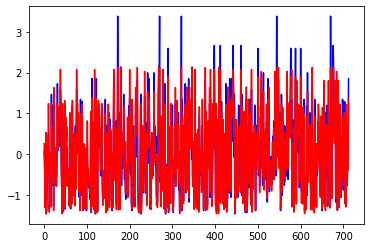

In [43]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, 
                          min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                          max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=None, 
                          random_state=42, verbose=0, warm_start=False)


# defining parameter range 
param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'warm_start': ['True', 'False']
             }
   
'''param_grid = {'n_estimators' : [10, 50, 100, 200],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'max_leaf_nodes' : [None, 10, 50, 100, 200], 
              'warm_start': ['True', 'False'],
              'bootstrap' : ['True', 'False'],
              'oob_score' :['True', 'False']
             } '''
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best Extra Trees Regressor 

MSE: 
 245201.5221282993

R2: 
 0.8895803169842437

MAPE: 
 [0.15448622]


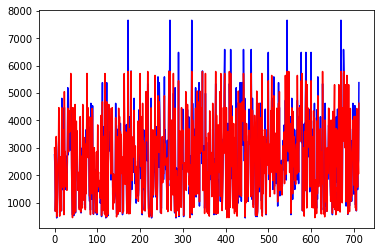

In [31]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn.ensemble import ExtraTreesRegressor
best_etr = ExtraTreesRegressor(bootstrap=False, criterion='mae', max_depth=10,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                    oob_score=False, random_state=42, verbose=0,
                    warm_start='True')
best_etr.fit(X_train, Y_train)
Y_pred = best_etr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)

# 9. Gradient boosting regression + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] criterion=mse, max_depth=3, n_estimators=10 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=10, score=-11.702, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=10, score=0.231, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] criterion=mse, max_depth=3, n_estimators=10 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=10, score=-2.327, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=20 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=20, score=-7.186, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=20 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=20, score=0.468, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=20 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=20, score=-1.254, total=   0.0s
[CV] criterion=mse, max_depth=3, n_estimators=50 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=50, score=-2.670, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50 .....................
[CV]  criterion=mse, max_depth=3, n_estimators=50, score=0.675, total=   0.1s
[CV] criterion=mse, max_depth=3, n_estimators=50 .....................
[CV]  criterion=mse, max_depth=

[CV] criterion=friedman_mse, max_depth=5, n_estimators=10 ............
[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, score=0.511, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=10 ............
[CV]  criterion=friedman_mse, max_depth=5, n_estimators=10, score=-2.047, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=20 ............
[CV]  criterion=friedman_mse, max_depth=5, n_estimators=20, score=-5.852, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=20 ............
[CV]  criterion=friedman_mse, max_depth=5, n_estimators=20, score=0.047, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=20 ............
[CV]  criterion=friedman_mse, max_depth=5, n_estimators=20, score=-1.022, total=   0.0s
[CV] criterion=friedman_mse, max_depth=5, n_estimators=50 ............
[CV]  criterion=friedman_mse, max_depth=5, n_estimators=50, score=-4.221, total=   0.1s
[CV] criterion=friedman_mse, max_depth=5, n_esti

[CV]  criterion=mae, max_depth=7, n_estimators=100, score=-4.815, total=   6.6s
[CV] criterion=mae, max_depth=7, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=7, n_estimators=100, score=-0.353, total=   6.9s
[CV] criterion=mae, max_depth=7, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=7, n_estimators=100, score=-0.588, total=   6.5s
[CV] criterion=mae, max_depth=10, n_estimators=10 ....................
[CV]  criterion=mae, max_depth=10, n_estimators=10, score=-10.624, total=   0.7s
[CV] criterion=mae, max_depth=10, n_estimators=10 ....................
[CV]  criterion=mae, max_depth=10, n_estimators=10, score=0.550, total=   0.7s
[CV] criterion=mae, max_depth=10, n_estimators=10 ....................
[CV]  criterion=mae, max_depth=10, n_estimators=10, score=-2.028, total=   0.7s
[CV] criterion=mae, max_depth=10, n_estimators=20 ....................
[CV]  criterion=mae, max_depth=10, n_estimators=20, score=-6.538, total=   1.5s
[CV] criterion

[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  4.5min finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'mae', 'max_depth': 3, 'n_estimators': 100}
GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
MSE =  0.09522938237472155
R2 score = 0.9047706176252784

Mean Absolute Percentage Error = [-0.23948159]
Mean Absolute Error is: 0.246452755323538


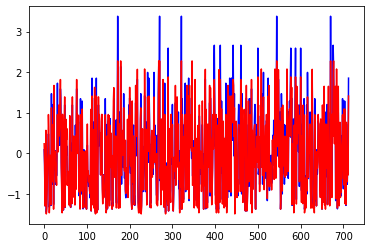

In [31]:
from sklearn import ensemble
reg = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100,
                                         subsample=1.0, criterion='friedman_mse', min_samples_split=2,
                                         min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                         min_impurity_decrease=0.0, min_impurity_split=None, 
                                         init=None, random_state= 42, max_features=None, 
                                         alpha=0.9, verbose=0, max_leaf_nodes=None, 
                                         warm_start=False, validation_fraction=0.1, n_iter_no_change=None, 
                                         tol=0.0001)
# defining parameter range
param_grid = {'n_estimators' : [10, 20, 50, 100],
              
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15, None ]
              
             }
'''param_grid = {'n_estimators' : [10, 20, 50, 100],
              'criterion': ['mse','friedman_mse', 'mae'],  
              'max_depth': [3,4,5,7,10,15 None ],
              'max_features' : ['auto', 'sqrt', 'log2', None],
              'max_leaf_nodes' : [None, 10, 20,50, 100], 
              'warm_start': ['True', 'False'],
              'loss' : ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate' : [0.1, 0.5, 0.01, 0.001, 0.0001],
              'subsample': [0.2, 0.4, 0.6, 0.8, 1],
              'validation_fraction': [0.2, 0.1, 0.3, 0.4]
             } '''
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# 10 fold cross validation for best GBR

MSE: 
 211469.44885077755

R2: 
 0.9047706176252784

MAPE: 
 [0.14167187]


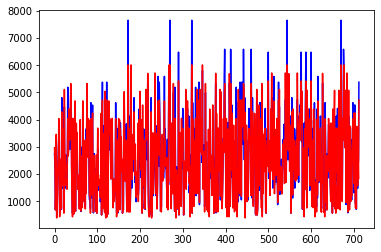

In [33]:
r2_scores = []
mse_scores = []
mape_scores = []
from sklearn import ensemble
best_gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
best_gbr.fit(X_train, Y_train)
Y_pred = best_gbr.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_fold, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)

# 10. XGB Boost + Grid Search

C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] learning_rate=0.1, max_depth=3, n_estimators=10 .................
[18:52:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, score=-20.223, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] learning_rate=0.1, max_depth=3, n_estimators=10 .................
[18:52:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, score=0.437, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] learning_rate=0.1, max_depth=3, n_estimators=10 .................
[18:52:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=10, score=-2.196, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, n_estimators=20 .................
[18:52:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=20, score=-14.395, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, n_estimators=20 .................
[18:52:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=3, n_estimators=20, score=0.757, total=   0.0s
[CV] learning_rate=0.1, max_depth=3, n_estimat

[18:52:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=10, n_estimators=20, score=-2.399, total=   0.0s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................
[18:52:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=10, n_estimators=50, score=-10.208, total=   0.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................
[18:52:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.1, max_depth=10, n_estimators=50, score=0.731, total=   0.1s
[CV] learning_rate=0.1, max_depth=10, n_estimators=50 ................
[18:52:36] WARNING: C:/Jenkins/workspace/xg

[18:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=5, n_estimators=50, score=-0.303, total=   0.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=100 ................
[18:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=5, n_estimators=100, score=-7.880, total=   0.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=100 ................
[18:52:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.5, max_depth=5, n_estimators=100, score=0.826, total=   0.1s
[CV] learning_rate=0.5, max_depth=5, n_estimators=100 ................
[18:52:40] WARNING: C:/Jenkins/workspace/xgbo

[18:52:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, max_depth=3, n_estimators=100, score=-2.575, total=   0.1s
[CV] learning_rate=0.01, max_depth=4, n_estimators=10 ................
[18:52:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, max_depth=4, n_estimators=10, score=-27.957, total=   0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=10 ................
[18:52:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, max_depth=4, n_estimators=10, score=-0.828, total=   0.1s
[CV] learning_rate=0.01, max_depth=4, n_estimators=10 ................
[18:52:45] WARNING: C:/Jenkins/workspace/

[18:52:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, max_depth=15, n_estimators=10, score=-0.940, total=   0.0s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............
[18:52:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, score=-26.934, total=   0.0s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............
[18:52:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, score=-0.561, total=   0.0s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............
[18:52:49] WARNING: C:/Jenkins/workspac

[18:52:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.001, max_depth=7, n_estimators=20, score=-0.795, total=   0.0s
[CV] learning_rate=0.001, max_depth=7, n_estimators=50 ...............
[18:52:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.001, max_depth=7, n_estimators=50, score=-28.543, total=   0.1s
[CV] learning_rate=0.001, max_depth=7, n_estimators=50 ...............
[18:52:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.001, max_depth=7, n_estimators=50, score=-0.992, total=   0.1s
[CV] learning_rate=0.001, max_depth=7, n_estimators=50 ...............
[18:52:53] WARNING: C:/Jenkins/workspac

[18:52:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.0001, max_depth=4, n_estimators=50, score=-1.137, total=   0.1s
[CV] learning_rate=0.0001, max_depth=4, n_estimators=50 ..............
[18:52:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.0001, max_depth=4, n_estimators=50, score=-0.768, total=   0.1s
[CV] learning_rate=0.0001, max_depth=4, n_estimators=100 .............
[18:52:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.0001, max_depth=4, n_estimators=100, score=-28.943, total=   0.1s
[CV] learning_rate=0.0001, max_depth=4, n_estimators=100 .............
[18:52:57] WARNING: C:/Jenkins/work

[18:53:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.0001, max_depth=15, n_estimators=100, score=-28.940, total=   0.2s
[CV] learning_rate=0.0001, max_depth=15, n_estimators=100 ............
[18:53:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.0001, max_depth=15, n_estimators=100, score=-1.122, total=   0.2s
[CV] learning_rate=0.0001, max_depth=15, n_estimators=100 ............
[18:53:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  learning_rate=0.0001, max_depth=15, n_estimators=100, score=-0.779, total=   0.1s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   30.4s finished
C:\Users\Rajat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[18:53:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, validate_parameters=False, verbosity=1)
MSE =  0.16332558302353925
R2 score = 0.8366744169764607

Mean Absolute Percentage Error = [-0.29265095]
Mean Absolute Error is: 0.3067703868119094


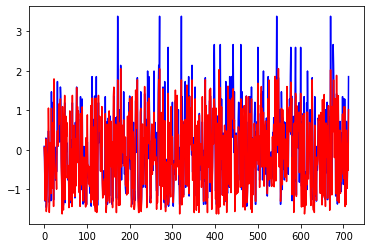

In [33]:
import xgboost as xgb
# data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
reg = xgb.XGBRegressor(booster = 'gbtree',validate_parameters = False,  
                objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
# defining parameter range 
param_grid = {'n_estimators' : [10, 20, 50, 100], 
              'max_depth': [3,4,5,7,10,15],
              'learning_rate' : [0.1, 0.5, 0.01, 0.001, 0.0001]      
             } 
grid = GridSearchCV(reg, param_grid, refit = True, verbose = 3)

# fitting the model for grid search 
grid.fit(X_train, Y_train) 

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
# clf = SVR(kernel = 'poly', degree= 15)
# clf.fit(X_train, Y_train)
Y_pred = grid.predict(X_test)
# Y_pred = reg.predict(X_test)
print('MSE = ', mean_squared_error(Y_test, Y_pred))
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
# print('Accuracy =',accuracy_score(Y_test, Y_pred))
print('R2 score =',r2_score(Y_test, Y_pred))
print('\nMean Absolute Percentage Error =',absolute_percentage_error(Y_test, Y_pred))
print('Mean Absolute Error is:',mean_absolute_error(Y_test, Y_pred))

# # 10 fold cross validation for best XGB 

[18:54:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 
 362686.0773709887

R2: 
 0.8366744164150086

MAPE: 
 [0.19883855]


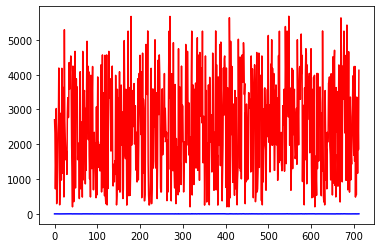

In [34]:
r2_scores = []
mse_scores = []
mape_scores = []
import xgboost as xgb
best_xgb = xgb.XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, validate_parameters=False, verbosity=1)
best_xgb.fit(X_train, Y_train)
Y_pred = best_xgb.predict(X_test)

Y_pred = scaler_y.inverse_transform(Y_pred)
Y_fold = scaler_y.inverse_transform(Y_test)
plt.figure()
plt.plot(Y_test, 'b')
plt.plot(Y_pred, 'r')
r2_scores = (r2_score(Y_fold, Y_pred))
mse_scores = (mean_squared_error(Y_fold, Y_pred))
mape_scores = (absolute_percentage_error(Y_fold, Y_pred))
print('MSE: \n', mse_scores)
print('\nR2: \n', r2_scores)
print('\nMAPE: \n', mape_scores)